In [32]:
import sys

sys.path.insert(0, "..")

import scipy.io
import numpy as np
import matplotlib.pyplot as plt

from HAR.transformers import CSIScaler


def load_dataset(infile):
    mat = scipy.io.loadmat(infile)
    X = mat["csi"].T
    nsamples = mat["nsamples"].flatten()
    dim = mat["dim"].flatten()
    classnames = list(map(lambda s: s.strip().title(), mat["classnames"]))
    y = []
    for i in range(len(classnames)):
        y += [i] * nsamples[i]
    y = np.array(y)
    return X, y, nsamples, classnames, dim


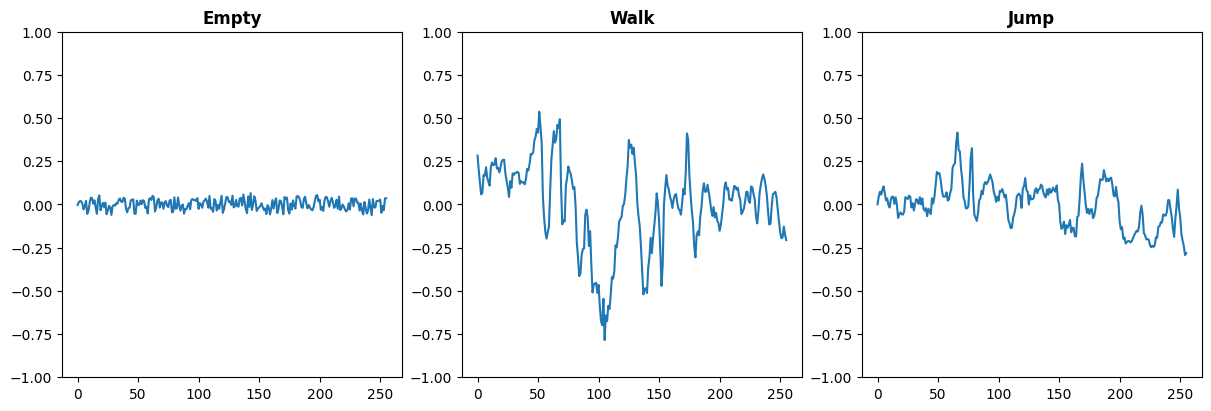

In [44]:
X, y, nsamples, classnames, dim = load_dataset("../dataset/rCSI-5.mat")

X = X.reshape(X.shape[0], *dim)
scaler = CSIScaler()

X = scaler.fit_transform(X, y)

plt.figure(figsize=(12, 4), constrained_layout=True)
for i in range(len(classnames)):
    sample = X[nsamples[:i].sum() + np.random.randint(0, nsamples[i]), :, :]
    U, _, _ = np.linalg.svd(sample)
    s = np.dot(U[:, 1], sample)

    plt.subplot(1, 3, i+1)
    plt.plot(s)
    plt.ylim([-1, 1])
    plt.title(classnames[i].title(), fontweight="bold")

plt.show()

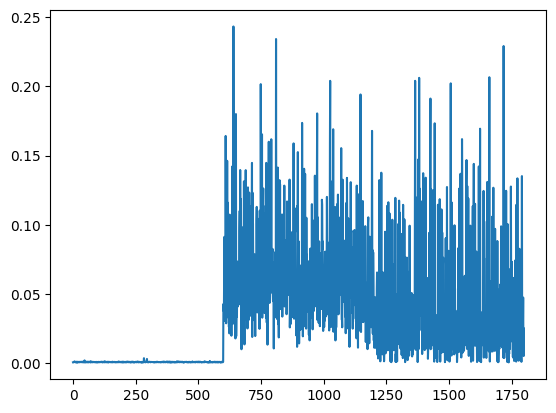

In [77]:
var = []

for i in range(X.shape[0]):
    s = X[i]
    U, _, _ = np.linalg.svd(s)

    q = U[:, 1]
    h = np.dot(q, s)

    var.append((h.std() ** 2))

var = np.array(var)

plt.plot(var)
plt.show()


In [79]:
from sklearn.metrics import confusion_matrix, accuracy_score
from scipy.optimize import fmin

y_actual = y.copy()
y_actual[y_actual != 0] = 1


def f(th):
    y_pred = np.zeros_like(var)
    y_pred[var > th] = 1
    return -accuracy_score(y_actual, y_pred)


th_opt = fmin(f, np.array([1e-3]))[0]

print("Optimal threshold:", th_opt)
y_pred = np.zeros_like(var)
y_pred[var > th_opt] = 1

print(confusion_matrix(y_actual, y_pred))


Optimization terminated successfully.
         Current function value: -0.985000
         Iterations: 7
         Function evaluations: 14
Optimal threshold: 0.0015000000000000013
[[ 594    6]
 [  21 1179]]
